In [1]:
#PARAMS

call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']


#Libraries and dependencies
import pickle
import re
import sys
import os
import matplotlib.cm as cm

base_dir = '/home/arianasp/meerkat_detector'
sys.path.append('/home/arianasp/meerkat_detector/dev')

from meerkat_call_detector_library import *  

eval_dir = base_dir + '/eval'

eval_files = os.listdir(eval_dir)
#eval_files = ['HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY_label_cnn_4epoch_20181102_no_aug_3600-7800_eval.pckl']

#Plot ROC curves for each file and save
for file_idx in range(len(eval_files)):
  eval_file = eval_files[file_idx]

  f = open(eval_dir + '/' + eval_file,'rb')
  output = pickle.load(f,encoding='latin1')
  f.close()

  colors = cm.rainbow(np.linspace(0, 1, len(output.threshes)))

  fig = plt.figure(figsize=(20,10))
  name = os.path.basename(output.pckl_path)
  plot_savename = base_dir + '/figures/' + name[0:(len(name)-4)] + 'pdf'
  
  if(not(os.path.isfile(plot_savename))):
    fig.suptitle(name)
    for i in range(0,8):
      ax = fig.add_subplot(2,4,i+1)
      ax.set_aspect('equal')
      ax.set_xlim(-.1,1.1)
      ax.set_ylim(-.1,1.1)
      if(int(output.true_pos_foc[0,i]+output.false_neg_foc[0,i]) > 0):
        ax.plot(output.precisions,output.recalls_foc[:,i],c='black',linewidth=0.2)
        ax.scatter(output.precisions,output.recalls_foc[:,i],c=colors,s=5)
      else:
        ax.text(0.5,0.5,'NA')
      ax.set_xlabel('precision')
      ax.set_ylabel('recall')
      ax.set_title(call_types[i] + ' (' + str(int(output.true_pos_foc[0,i]+output.false_neg_foc[0,i])) + ')')
    fig.savefig(plot_savename, bbox_inches='tight')

Using TensorFlow backend.
/home/arianasp/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


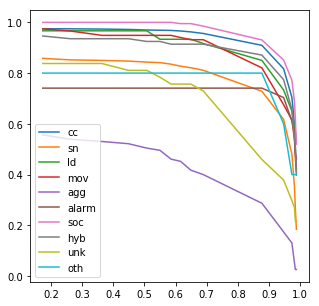

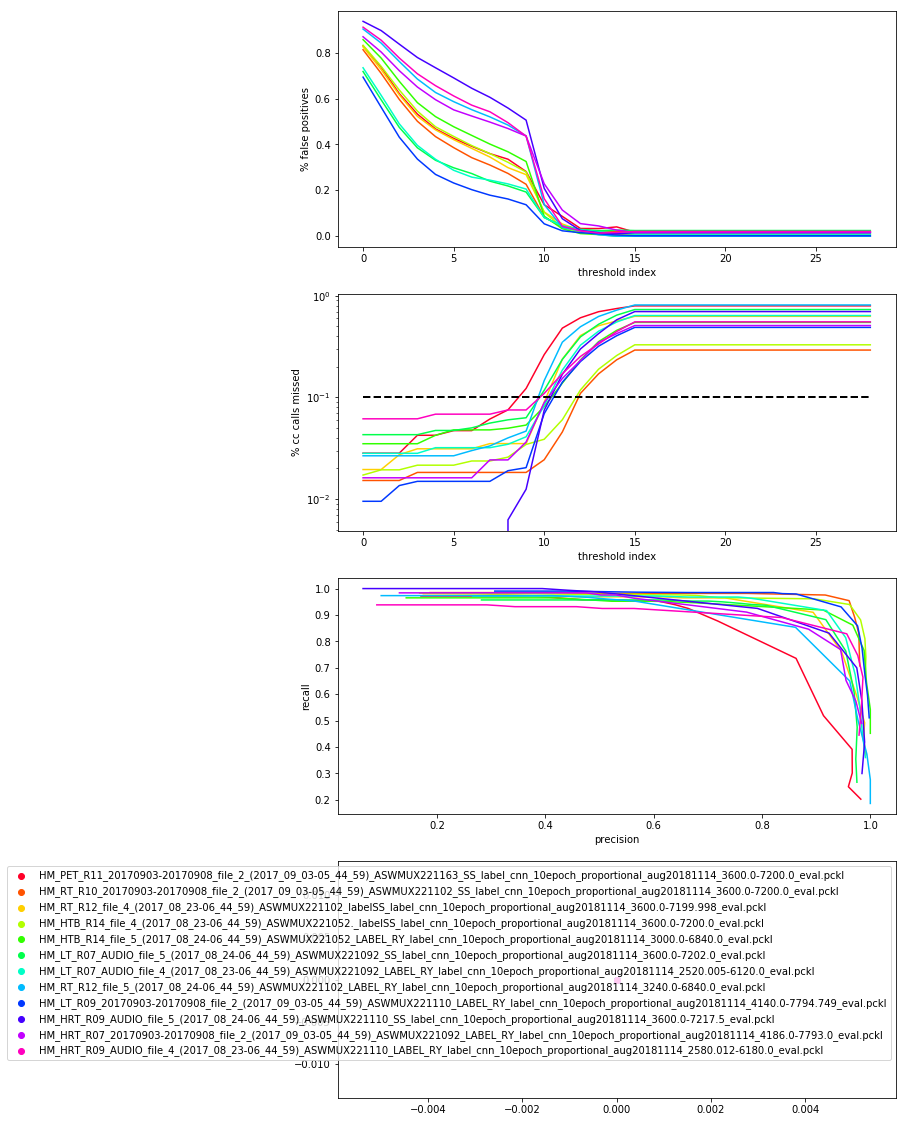

In [5]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

curr_model = 'cnn_10epoch_proportional_aug20181114'

#separate training and testing (training was files labeled by me, testing on files labeled by students)
eval_dir = '/home/arianasp/meerkat_detector/eval'
all_files = os.listdir('/home/arianasp/meerkat_detector/eval/')
train_files = []
eval_files = []
for i in range(len(all_files)):
    if(re.search(curr_model,all_files[i]) and not re.search('HM_HMB',all_files[i])):
        if(re.search('RY',all_files[i]) or re.search('SS',all_files[i])):
            eval_files.append(all_files[i])
        else:
            train_files.append(all_files[i])
        

#get shared parameters (threshes and call_types)
i = 0
file = eval_dir + '/' + eval_files[i]
f = open(file,'rb')
results = pickle.load(file=f,encoding='latin1')
threshes = results.threshes
call_types = results.call_types

#create variables to store all data
dim0 = results.true_pos_foc.shape[0]
dim1 = results.true_pos_foc.shape[1]
dim2 = len(eval_files)

true_pos_foc_all = np.zeros((dim0,dim1,dim2))
recalls_foc_all = np.zeros((dim0,dim1,dim2))
precision_foc_all = np.zeros((dim0,dim2))
true_pos_foc_combined = np.zeros((dim0,dim1))
false_neg_foc_combined = np.zeros((dim0,dim1))

#store data in big arrays
for i in range(len(eval_files)):
    file = eval_dir + '/' + eval_files[i]
    f = open(file,'rb')
    results = pickle.load(file=f,encoding='latin1')
    true_pos_foc_all[:,:,i] = results.true_pos_foc
    recalls_foc_all[:,:,i] = results.recalls_foc
    precision_foc_all[:,i] = results.precisions
    true_pos_foc_combined = true_pos_foc_combined + results.true_pos_foc
    false_neg_foc_combined = false_neg_foc_combined + results.false_neg_foc

#Combined precision and recall across all files
recall_combined = true_pos_foc_combined / (true_pos_foc_combined + false_neg_foc_combined)
precision_combined = np.zeros(len(threshes))
#get average precision
for i in range(len(threshes)):
    precision_combined[i] = np.mean(precision_foc_all[i,:])
plt.figure(figsize=(5,5))
for i in range(len(call_types)):
    plt.plot(precision_combined,recall_combined[:,i])
plt.legend(call_types)
plt.show()
    
#make plots
colors = cm.gist_rainbow(np.linspace(0, 1, len(eval_files)))
ls = 'solid'
fig = plt.figure(figsize=(10,20))
call_type_idx = 0

#plot of threshold values vs indices
#ax = fig.add_subplot(4,1,1)
#ax.plot(-threshes+1)
#ax.scatter(np.arange(0,len(threshes)),-threshes+1)
#ax.semilogy()
#ax.set_xlabel('threshold index')
#ax.set_ylabel('1 - threshold value')
ax = fig.add_subplot(4,1,1)
for i in range(len(eval_files)):
    ax.plot(-precision_foc_all[:,i]+1,color=colors[i],linestyle=ls)
ax.set_xlabel('threshold index')
ax.set_ylabel('% false positives')
ax = fig.add_subplot(4,1,2)
for i in range(len(eval_files)):
    ax.plot(-recalls_foc_all[:,call_type_idx,i]+1,color=colors[i],linestyle=ls)
ax.set_xlabel('threshold index')
ax.set_ylabel('% ' + call_types[call_type_idx] + ' calls missed')
ax.plot([0,len(threshes)-1],[.1,.1],color='black',linewidth=2,linestyle='dashed')
ax.semilogy()
ax = fig.add_subplot(4,1,3)
ax.set_xlabel('precision')
ax.set_ylabel('recall')
for i in range(len(eval_files)):
    ax.plot(precision_foc_all[:,i],recalls_foc_all[:,call_type_idx,i],color=colors[i],linestyle=ls)
ax2 = fig.add_subplot(4,1,4)
#for i in range(len(eval_files)):
#    custom_lines.append(plt.Line2D([0], [0], color=colors[i]))
for i in range(len(eval_files)):
    ax2.scatter(0,0,color=colors[i])
ax2.legend(eval_files)

cc


Text(0, 0.5, 'Recall at thresh_idx 8')

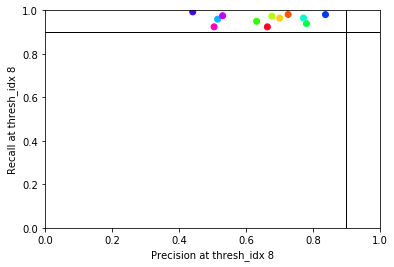

In [73]:
call_idx = 0
thresh_idx = 8
print(call_types[call_idx])
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1],[0.9,0.9],color='black',linewidth=1)
plt.plot([0.9,0.9],[0,1],color='black',linewidth=1)
plt.scatter(precision_foc_all[thresh_idx,:],recalls_foc_all[thresh_idx,call_idx,:],c=colors)
plt.xlabel('Precision at thresh_idx ' + str(thresh_idx))
plt.ylabel('Recall at thresh_idx ' + str(thresh_idx))

In [4]:
print(eval_files)

['HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY_label_cnn_20epoch_proportional_aug20181115_2580.012-6180.0_eval.pckl', 'HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163_label_label_cnn_10epoch_proportional_aug20181114_3600.0-7225.381_eval.pckl', 'HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110_label_label_cnn_10epoch_proportional_aug20181114_3599.992-7417.688_eval.pckl', 'HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102_label_label_cnn_10epoch_proportional_aug20181114_3599.994-7429.14_eval.pckl', 'HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_SS_label_cnn_4epoch_proportional_aug_mel_20181124_nonorm_3600.0-7217.5_eval.pckl', 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS_label_cnn_10epoch_proportional_aug20181114_3600.0-7200.0_eval.pckl', 'HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label_label_cnn_10epoch_proportional_aug20181114_3600.0-7325.0_eval.pckl', 

In [3]:
file

NameError: name 'file' is not defined

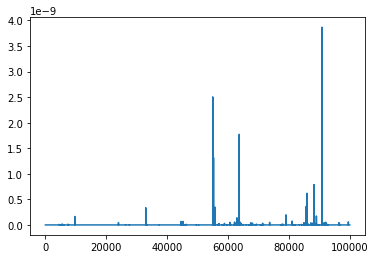

In [18]:
import pickle
pred = pickle.load(open('/home/arianasp/meerkat_detector/predictions/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS_label_cnn_10epoch_proportional_aug_spec_20181205_1-16200.0.pckl','rb'))
plt.plot(pred.scores[200000:300000])